In [1]:
import sys, os

sys.path.append("../")
from src.qaoa_scheduling import QAOACircuit, QAOAScheduler

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import pandas as pd
import seaborn as sns

In [2]:
def create_circuit_with_times(
    n_qubits: int, is_complete: bool, time_range: Tuple[float, float], seed: int = None
) -> QAOACircuit:
    """Create a circuit with specified parameters."""
    if seed is not None:
        np.random.seed(seed)

    gamma_gates = {}
    if is_complete:
        # Complete graph: connect each vertex to all others
        for i in range(n_qubits):
            for j in range(i + 1, n_qubits):
                gamma_gates[(i, j)] = np.round(np.random.uniform(*time_range), 3)
    else:
        # Cyclic graph: connect each vertex to next one
        for i in range(n_qubits):
            gamma_gates[(i, (i + 1) % n_qubits)] = np.round(
                np.random.uniform(*time_range), 3
            )

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=1.0)


def analyze_circuit(circuit: QAOACircuit) -> Dict:
    """Analyze a circuit and return key metrics."""
    scheduler = QAOAScheduler(circuit)
    result = scheduler.solve_lp()

    n_edges = len(circuit.gamma_gates)
    total_time = sum(circuit.gamma_gates.values())
    max_time = max(circuit.gamma_gates.values())
    min_time = min(circuit.gamma_gates.values())
    time_range = max_time - min_time

    return {
        "n_vertices": circuit.n_qubits,
        "n_edges": n_edges,
        "total_time_before": result.total_time_before,
        "total_time_after": result.total_time_after,
        "improvement": result.improvement,
        "improvement_percentage": 100
        * (result.improvement / result.total_time_before),  # Convert to percentage
        "n_layers": len(result.cost_layers),
        "avg_time": total_time / n_edges,
        "max_time": max_time,
        "min_time": min_time,
        "time_range": time_range,
    }


def run_parameter_study(
    vertex_range: range,
    n_trials: int,
    time_ranges: List[Tuple[float, float]],
    include_complete: bool = True,
    include_cyclic: bool = True,
) -> pd.DataFrame:
    """Run comprehensive parameter study."""
    results = []

    for n_vertices in vertex_range:
        for time_range in time_ranges:
            for trial in range(n_trials):
                if include_cyclic:
                    cyclic_circuit = create_circuit_with_times(
                        n_vertices, False, time_range, seed=42 + n_vertices + trial
                    )
                    metrics = analyze_circuit(cyclic_circuit)
                    metrics["graph_type"] = "Cyclic"
                    metrics["time_range_label"] = f"{time_range[0]}-{time_range[1]}"
                    results.append(metrics)

                if include_complete:
                    complete_circuit = create_circuit_with_times(
                        n_vertices, True, time_range, seed=42 + n_vertices + trial
                    )
                    metrics = analyze_circuit(complete_circuit)
                    metrics["graph_type"] = "Complete"
                    metrics["time_range_label"] = f"{time_range[0]}-{time_range[1]}"
                    results.append(metrics)

    return pd.DataFrame(results)

In [ ]:
# Run analysis
vertex_range = range(3, 8)
n_trials = 5  # Number of random trials per configuration
time_ranges = [(1, 5), (1, 10), (5, 15)]  # Different time distributions to study

# Execute parameter study
results_df = run_parameter_study(vertex_range, n_trials, time_ranges)

In [ ]:
# Print summary statistics
print("\nSummary Statistics:")
print("=" * 50)
for graph_type in ["Cyclic", "Complete"]:
    print(f"\n{graph_type} Graphs:")
    group = results_df[results_df["graph_type"] == graph_type]
    print(f"Average improvement: {group['improvement_percentage'].mean():.1f}%")
    print(f"Max improvement: {group['improvement_percentage'].max():.1f}%")
    print(f"Average number of layers: {group['n_layers'].mean():.1f}")

    # Correlation analysis
    correlations = group[
        ["n_vertices", "n_edges", "time_range", "improvement_percentage"]
    ].corr()["improvement_percentage"]
    print("\nCorrelations with improvement percentage:")
    print(correlations)

# Save results to CSV
os.makedirs("./data", exist_ok=True)
# Save CSV file in data directory
csv_filename = f"./data/qaoa_parameter_study_{vertex_range[-1]}vertices.csv"
results_df.to_csv(csv_filename, index=False)


Summary Statistics:

Cyclic Graphs:
Average improvement: 32.5%
Max improvement: 60.1%
Average number of layers: 4.5

Correlations with improvement percentage:
n_vertices                0.923946
n_edges                   0.923946
time_range                0.026895
improvement_percentage    1.000000
Name: improvement_percentage, dtype: float64

Complete Graphs:
Average improvement: 37.1%
Max improvement: 63.1%
Average number of layers: 8.5

Correlations with improvement percentage:
n_vertices                0.928867
n_edges                   0.887546
time_range                0.168479
improvement_percentage    1.000000
Name: improvement_percentage, dtype: float64


In [ ]:
# Set style for publication-quality plots
plt.style.use("seaborn-v0_8-paper")
sns.set_palette("deep")
plt.rcParams.update(
    {
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "font.family": "serif",
        "figure.figsize": (8, 6),
        "lines.linewidth": 2,
        "lines.markersize": 8,
    }
)

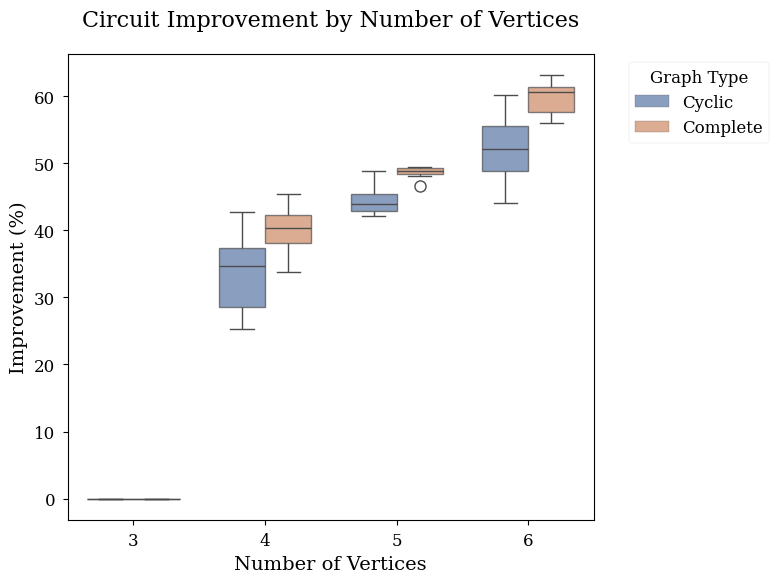

In [ ]:
# Plot 1: Improvement vs Vertices
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=results_df,
    x="n_vertices",
    y="improvement_percentage",
    hue="graph_type",
    boxprops={"alpha": 0.7},
    width=0.7,
)
plt.title("Circuit Improvement by Number of Vertices", pad=20)
plt.xlabel("Number of Vertices")
plt.ylabel("Improvement (%)")
plt.legend(title="Graph Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    f"./plots/improvement_vs_vertices_{vertex_range[-1]}vertices.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

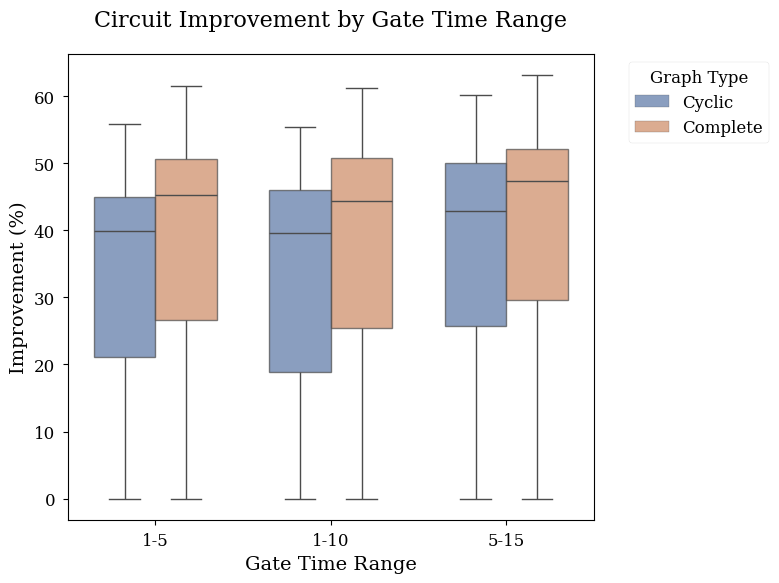

In [ ]:
# Plot 2: Improvement vs Time Range
plt.figure(figsize=(8, 6))
bp = sns.boxplot(
    data=results_df,
    x="time_range_label",
    y="improvement_percentage",
    hue="graph_type",
    boxprops={"alpha": 0.7},
    width=0.7,
)
plt.title("Circuit Improvement by Gate Time Range", pad=20)
plt.xlabel("Gate Time Range")
plt.ylabel("Improvement (%)")
plt.legend(title="Graph Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    f"./plots/improvement_vs_timerange_{vertex_range[-1]}vertices.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

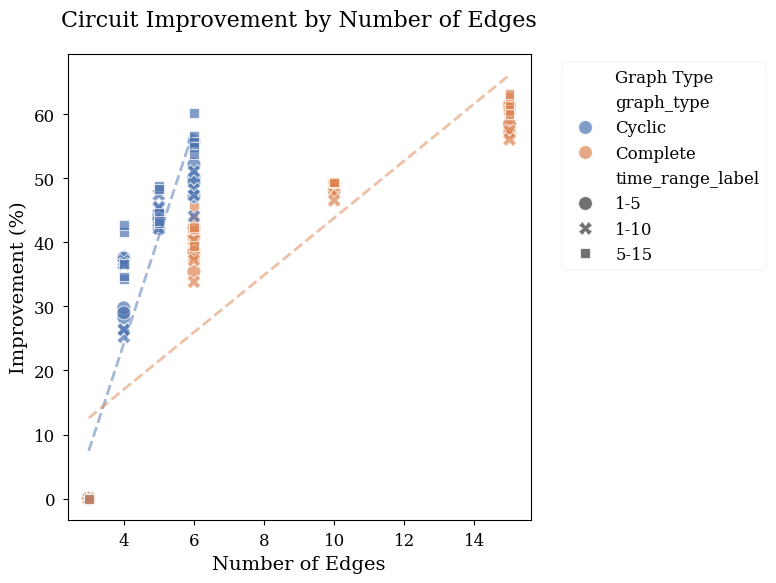

In [ ]:
# Plot 3: Improvement vs Edges (with enhanced scatter plot)
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=results_df,
    x="n_edges",
    y="improvement_percentage",
    hue="graph_type",
    style="time_range_label",
    s=100,  # Larger markers
    alpha=0.7,
)
plt.title("Circuit Improvement by Number of Edges", pad=20)
plt.xlabel("Number of Edges")
plt.ylabel("Improvement (%)")
# Add trend lines
for graph_type in results_df["graph_type"].unique():
    data = results_df[results_df["graph_type"] == graph_type]
    z = np.polyfit(data["n_edges"], data["improvement_percentage"], 1)
    p = np.poly1d(z)
    plt.plot(data["n_edges"], p(data["n_edges"]), linestyle="--", alpha=0.5)
plt.legend(title="Graph Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    f"./plots/improvement_vs_edges_{vertex_range[-1]}vertices.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

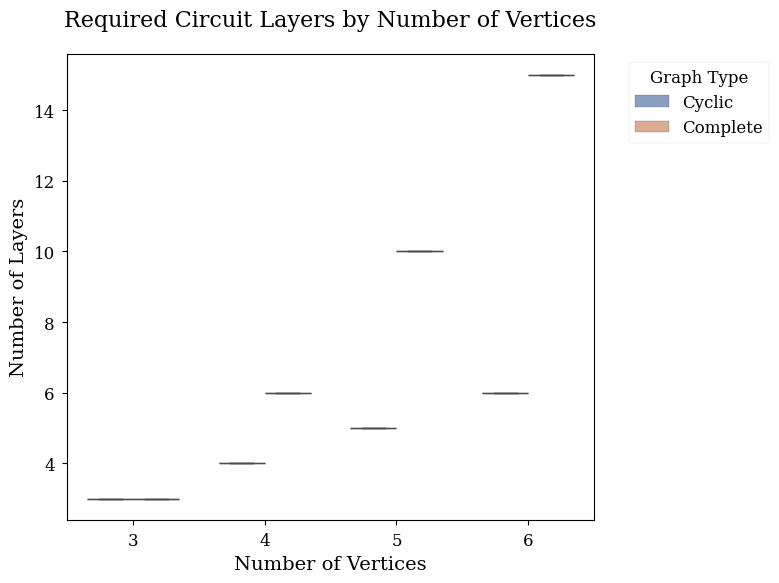

In [ ]:
# Plot 4: Layers vs Vertices
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=results_df,
    x="n_vertices",
    y="n_layers",
    hue="graph_type",
    boxprops={"alpha": 0.7},
    width=0.7,
)
plt.title("Required Circuit Layers by Number of Vertices", pad=20)
plt.xlabel("Number of Vertices")
plt.ylabel("Number of Layers")
plt.legend(title="Graph Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    f"./plots/layers_vs_vertices_{vertex_range[-1]}vertices.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

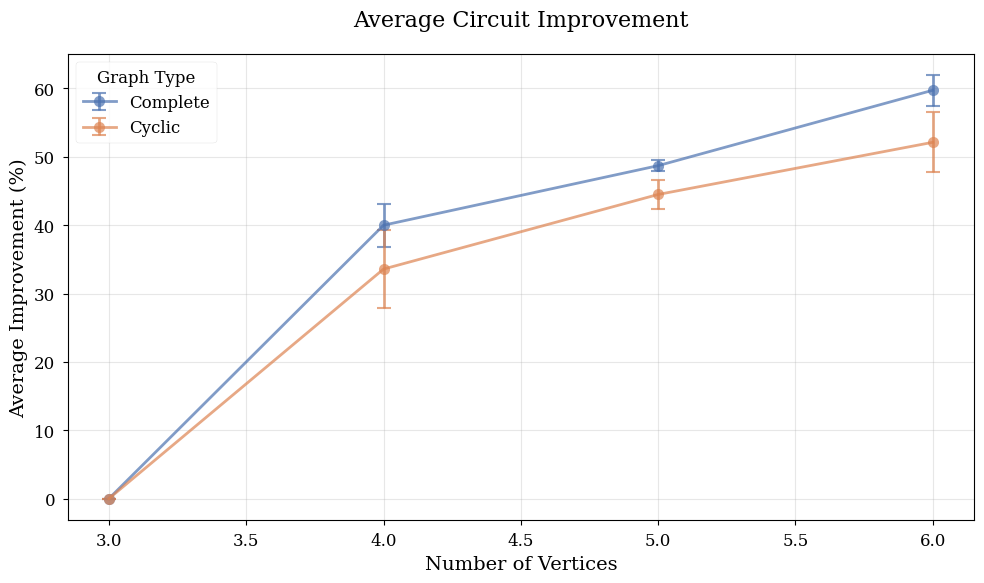

In [ ]:
# Create a summary plot with additional statistical information
plt.figure(figsize=(10, 6))
summary_data = (
    results_df.groupby(["graph_type", "n_vertices"])["improvement_percentage"]
    .agg(["mean", "std"])
    .reset_index()
)

for graph_type in summary_data["graph_type"].unique():
    data = summary_data[summary_data["graph_type"] == graph_type]
    plt.errorbar(
        data["n_vertices"],
        data["mean"],
        yerr=data["std"],
        label=graph_type,
        marker="o",
        capsize=5,
        capthick=1.5,
        markersize=8,
        alpha=0.7,
    )

plt.title("Average Circuit Improvement", pad=20)
plt.xlabel("Number of Vertices")
plt.ylabel("Average Improvement (%)")
plt.legend(title="Graph Type")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(
    f"./plots/improvement_summary_{vertex_range[-1]}vertices.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()